In [1]:
###Comparison of multiple distributions
#1. Descriptive Analysis
#2.Analysis of Variance
#3.Multiple t-test and Bonferroni correction
#4.Tukey's HSD

In [ ]:
# Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests
from statsmodels.stats import weightstats
import statsmodels.api as sm
from statsmodels.formula.api import ols


In [ ]:
# Set the size of figures
sns.set(rc={'figure.figsize':(15,8)}, font_scale = 1.5)
sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

In [ ]:
# Read data
df_babies = pd.read_csv('babies.csv', encoding="ISO-8859-1")

#Part 1 - Descriptive Analysis

In [ ]:
# Check for null values
df_babies.isnull().sum()

Unnamed: 0     0
id             0
pluralty       0
outcome        0
date           0
gestation      0
sex            0
wt            10
parity         0
race           0
age            0
ed             0
ht             0
wt1            0
drace          0
dage           0
ded            0
dht            0
dwt            0
marital        0
inc            0
smoke          0
time           0
number         0
dtype: int64

In [ ]:
df_smoke_babies=df_babies.drop(columns=['gestation', 'pluralty','outcome','date','sex','parity','race','age','ed','ht','wt1','drace','dage','ded','dht',
                                        'dht','dwt','marital','inc','time','number','id'])

# Drop the column with no name using iloc
df_smoke_babies = df_smoke_babies.drop(df_smoke_babies.columns[0], axis=1)

In [ ]:
df_smoke_babies=df_smoke_babies[df_smoke_babies['smoke'] != 9]

In [ ]:
# calculate parameters
babies = df_smoke_babies['wt'].describe()
babies.to_latex('describe.tex')
babies

<ipython-input-37-0685aed2de87>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  babies.to_latex('describe.tex')


count   1216.000
mean     119.562
std       18.140
min       55.000
25%      109.000
50%      120.000
75%      131.000
max      176.000
Name: wt, dtype: float64

In [ ]:
# calculate the mean of each smoking categories
df_means = df_smoke_babies.groupby(['smoke']).describe()
df_means.to_latex('mean_smoke.tex')
df_means

<ipython-input-38-fcf7f10373ee>:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_means.to_latex('mean_smoke.tex')


wt                                                      
        count    mean    std    min     25%     50%     75%     max
smoke                                                              
0     540.000 122.861 17.060 55.000 113.750 124.000 132.250 176.000
1     481.000 114.108 17.973 58.000 102.000 115.000 126.000 163.000
2      95.000 123.084 17.804 62.000 112.000 122.000 136.500 163.000
3     100.000 124.630 18.570 65.000 112.000 124.500 138.000 170.000

In [ ]:
#Check is there any missing values in the Data set
na_count = df_smoke_babies.isna().sum()
na_count

wt       10
smoke     0
dtype: int64

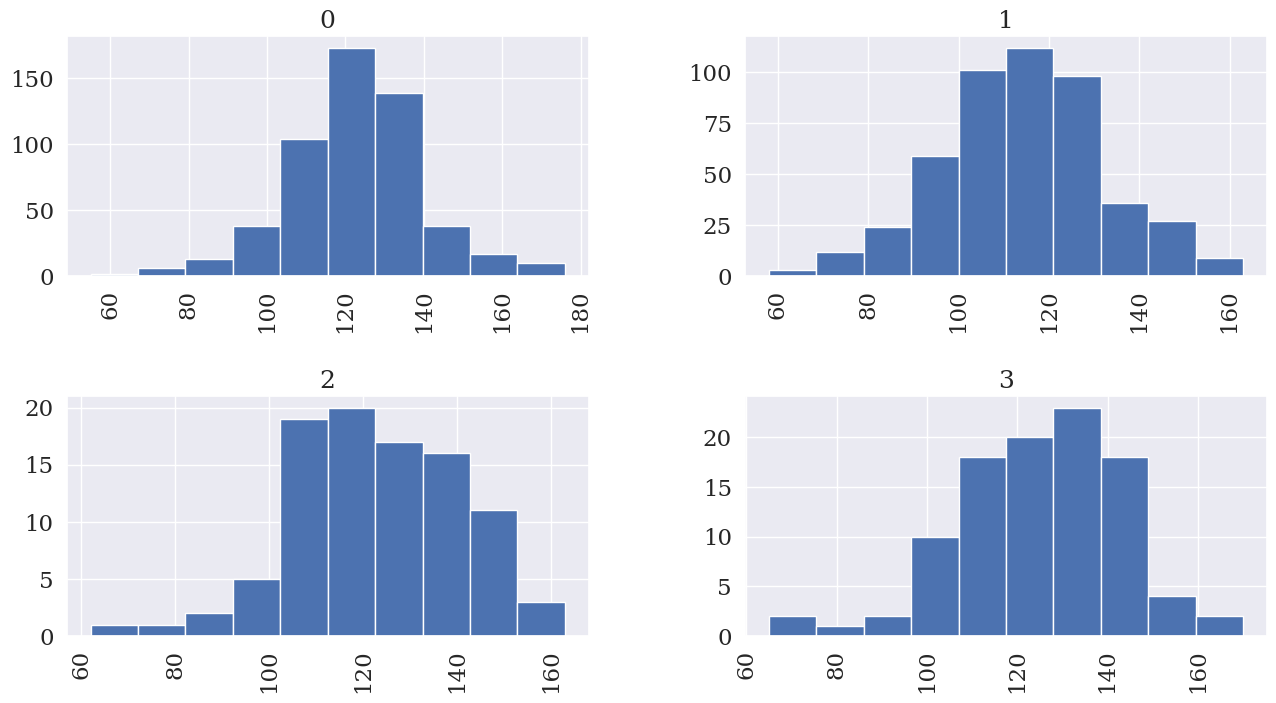

In [ ]:
# Visualise data using histograms
df_smoke_babies['wt'].hist(by=df_smoke_babies['smoke'])
plt.savefig('histogram_category.pdf')
plt.show()

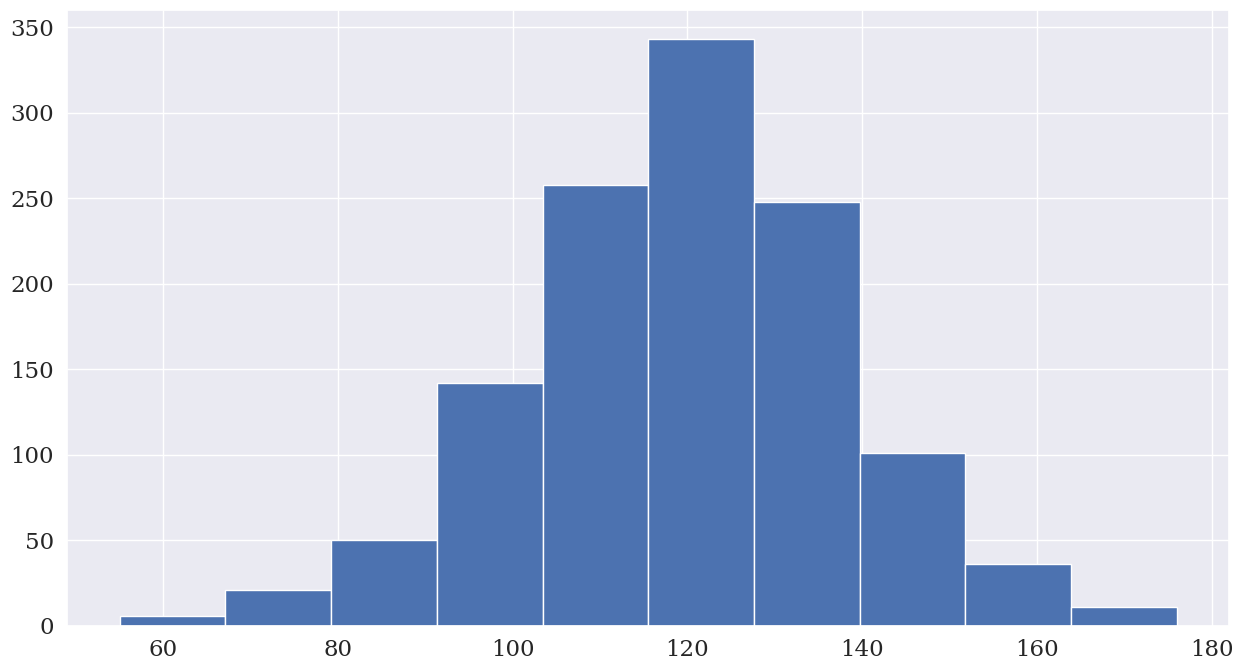

In [ ]:
# Visualise overall distribution
df_smoke_babies['wt'].hist()
plt.savefig('histogram.pdf')
plt.show()


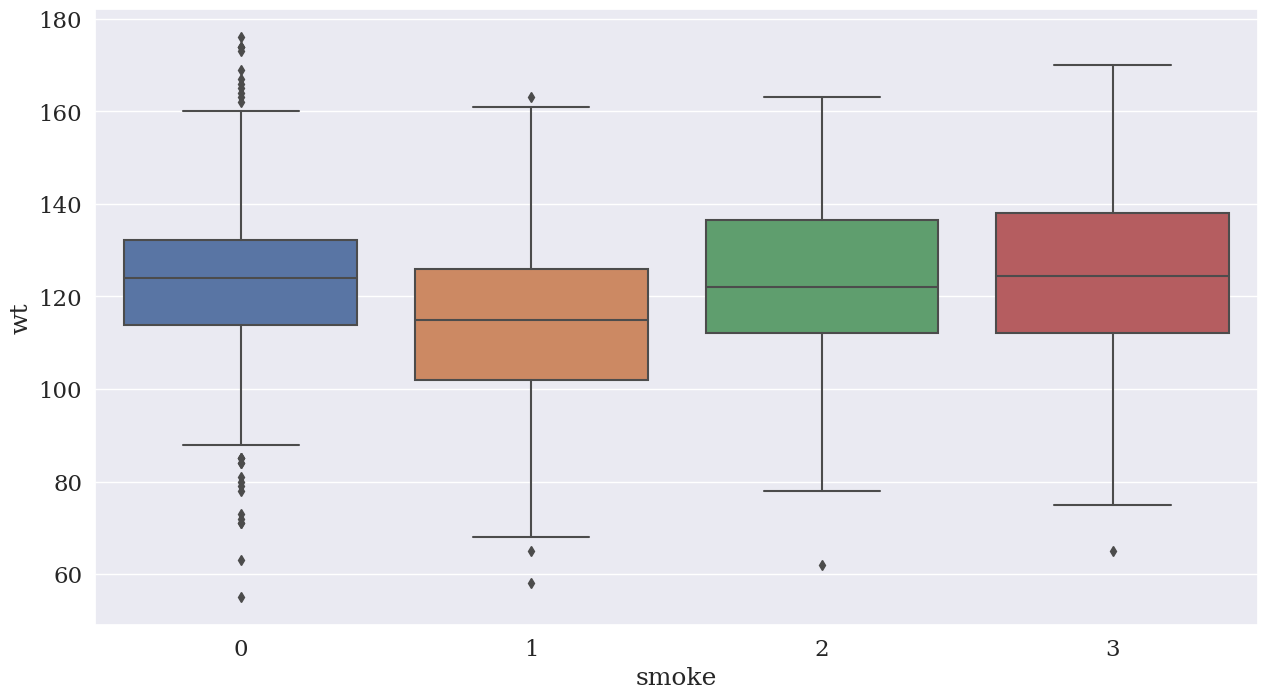

In [ ]:
# Generate box plots to show variability within/between smoke category
sns.boxplot(x = 'smoke', y = 'wt', data = df_smoke_babies)
plt.savefig('boxplots.pdf')
plt.show()


In [ ]:
# calculate sample variances
df_smoke_babies.groupby('smoke')['wt'].var()

smoke
0   291.051
1   323.017
2   316.972
3   344.862
Name: wt, dtype: float64

In [ ]:
# Define function for Q-Q plot
def qq_plots(smoke_cat):
    fig = sm.qqplot(df_smoke_babies[df_smoke_babies['smoke'] == smoke_cat]['wt'], line = '45', fit = True)
    plt.savefig(smoke_cat + '.pdf')
    plt.title('QQ Plot for Smoking Category ' + smoke_cat)
    plt.savefig('qqplot.pdf')
    plt.show()

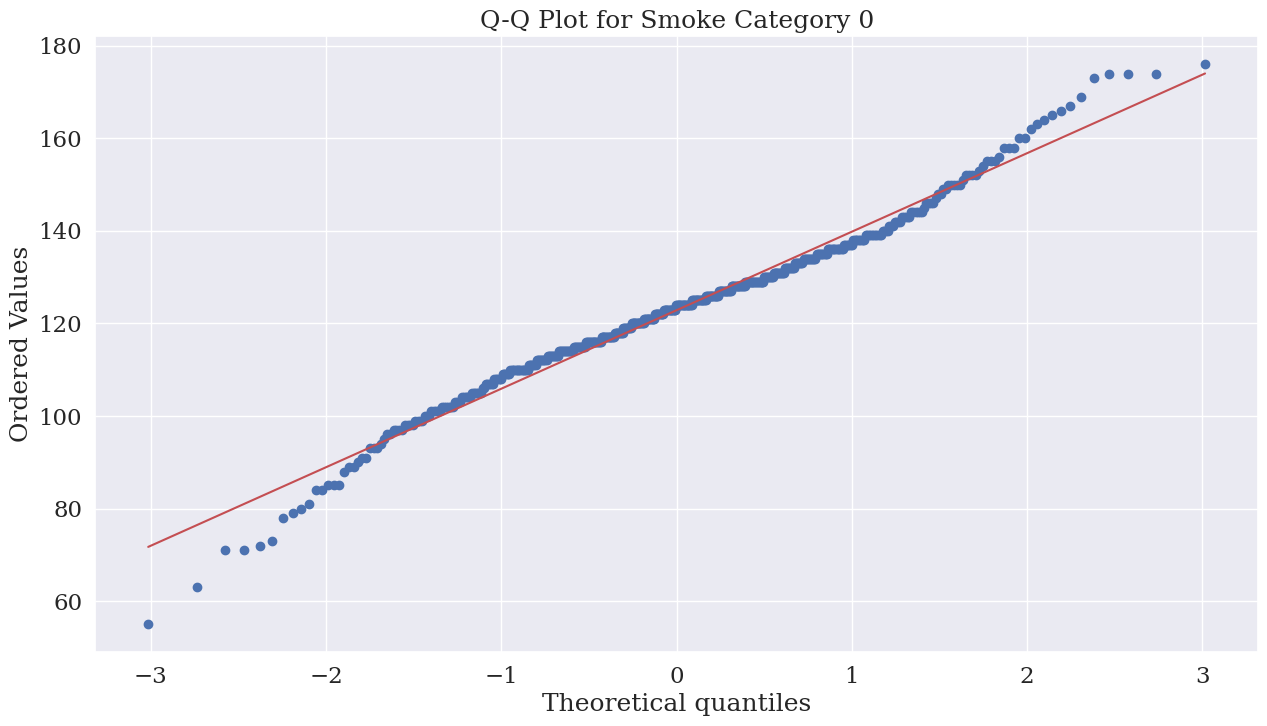

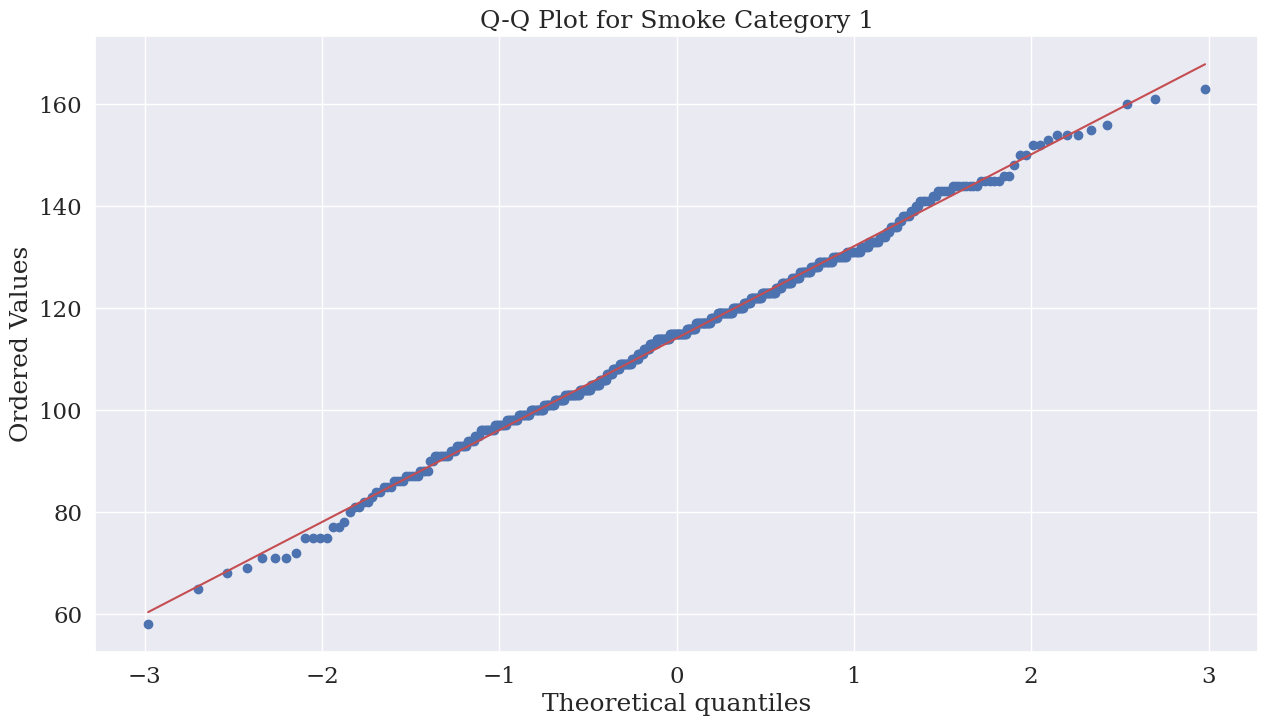

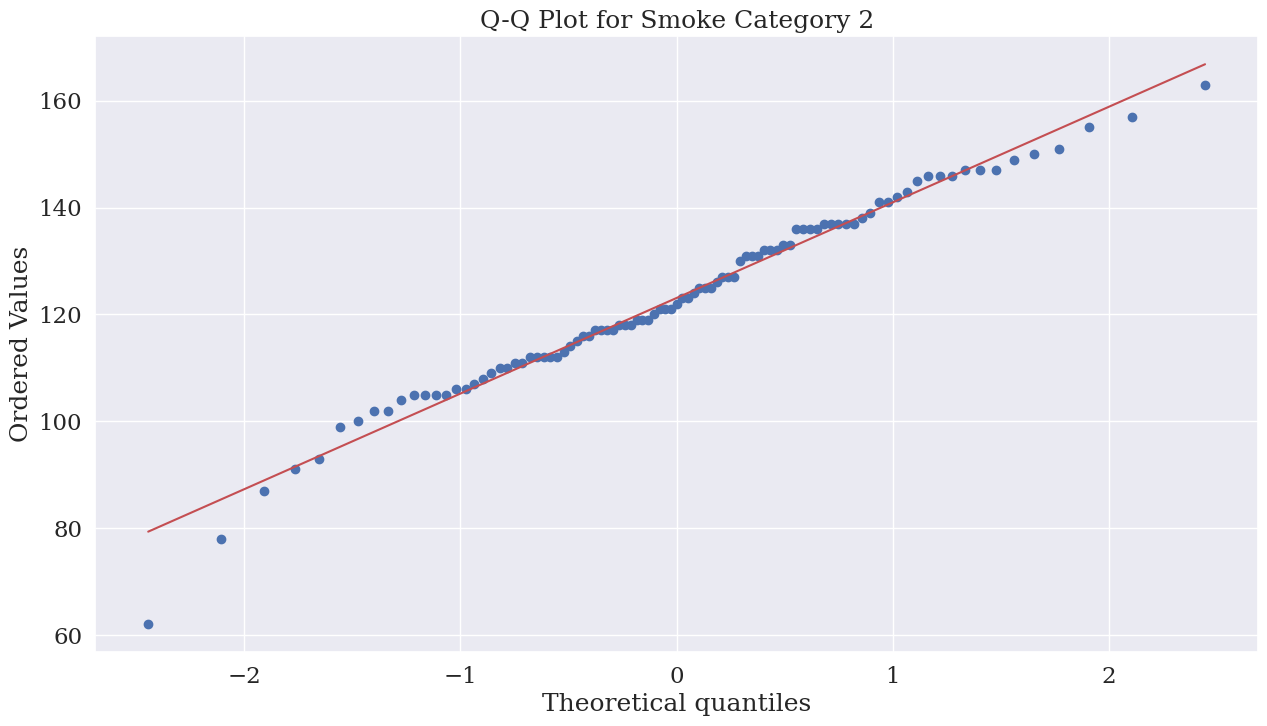

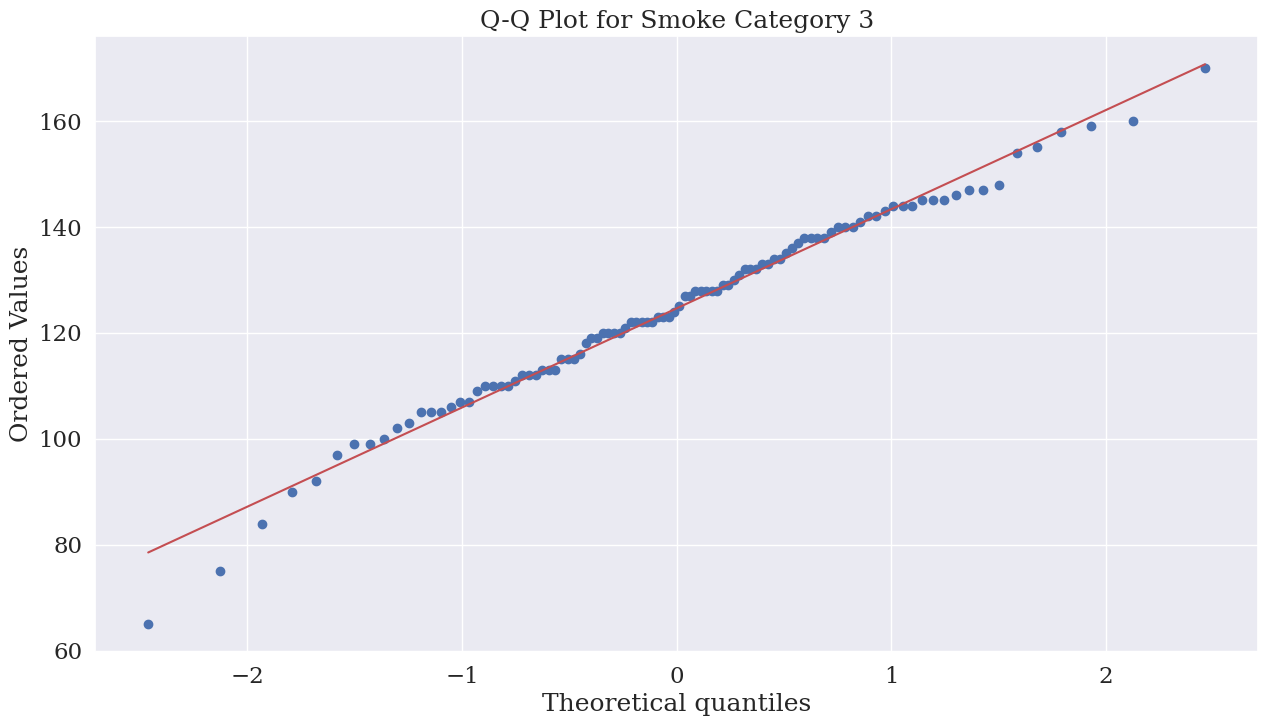

In [ ]:

# Remove rows with non-finite values
df_smoke_babies = df_smoke_babies.dropna(subset=['wt'])

# Group the data by 'smoke' category
groups = df_smoke_babies.groupby('smoke')['wt']

# Generate Q-Q plots
for smoke, group in groups:
    stats.probplot(group, dist='norm', plot=plt)
    plt.title(f"Q-Q Plot for Smoke Category {smoke}")
    plt.show()


##Part 2 - Analysis of Variance

In [ ]:
# Get group-wise data
smoke_groups = pd.unique(df_smoke_babies.smoke.values)
smoke_groups
l_data = [df_smoke_babies['wt'][df_smoke_babies.smoke == grp] for grp in smoke_groups]

In [ ]:
# calculate F-ratio
pd.set_option('display.float_format', lambda x: '%.3f' % x)
model = ols('wt ~ smoke', data=df_smoke_babies).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table.to_latex('anova_table.tex')
anova_table

<ipython-input-68-8e5aca16cc18>:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  anova_table.to_latex('anova_table.tex')


,sum_sq,df,F,PR(>F)
smoke,190.563,1.000,0.579,0.447
Residual,399602.811,1214.000,NaN,NaN


In [ ]:
# calculate p-value
f, p = stats.f_oneway(*l_data)
f, p

(25.723398227943612, 3.913951373335263e-16)

#Part 3 - Multiple t-tests and Bonferroni Correction

In [ ]:
# Apply t-test for two means that returns p-value for given pair of smoke category
def pairwise_testing(smoke_pair, equal_var):
    first_frame = df_smoke_babies[df_smoke_babies['smoke'] == smoke_pair[0]]['wt']
    second_frame = df_smoke_babies[df_smoke_babies['smoke'] == smoke_pair[1]]['wt']
    stat, p_value, df = weightstats.ttest_ind(first_frame, second_frame, alternative='two-sided', usevar='pooled')
    return p_value

In [ ]:
# Generate pairs of smoke category and applying t-test for each pair
p_values = []
comb_names = []
import itertools
for comb in itertools.combinations(smoke_groups, 2):
    comb_names.append('Category ' + str(comb[0]) + ' & ' +'Category '+ str(comb[1]))
    p_value = pairwise_testing(comb, True)
    p_values.append(p_value)

In [ ]:
# Apply Bonferroni Correction
adjusted_result = multipletests(p_values, alpha = 0.05, method = 'bonferroni')

In [ ]:
# Sort the results into a single dataframe
df_t_results = pd.DataFrame(columns = ['Smoke Pair', 'p-value', 'Adjusted p-value'])
df_t_results['Smoke Pair'] = comb_names
df_t_results['p-value'] = p_values
df_t_results['Rejected'] = df_t_results['p-value'] < 0.05
df_t_results['Adjusted p-value'] = adjusted_result[1]
df_t_results['Rejected_Adjusted'] = adjusted_result[0]

In [ ]:
# Importing for Latex
df_t_results.to_latex('ttest_results.tex')

<ipython-input-53-852f1ebf3865>:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_t_results.to_latex('ttest_results.tex')


In [ ]:
# Display results of task 3
df_t_results

,Smoke Pair,p-value,Adjusted p-value,Rejected,Rejected_Adjusted
0,Category 0 & Category 1,0.000,0.000,True,True
1,Category 0 & Category 3,0.348,1.000,False,False
2,Category 0 & Category 2,0.907,1.000,False,False
3,Category 1 & Category 3,0.000,0.000,True,True
4,Category 1 & Category 2,0.000,0.000,True,True
5,Category 3 & Category 2,0.554,1.000,False,False


#Part 4 - Tukey's HSD

In [ ]:

# Perform pairwise two-sample tests with Tukey's HSD
tukey_results = pairwise_tukeyhsd(df_smoke_babies['wt'], df_smoke_babies['smoke'])

# Print the Tukey's HSD results
print("Tukey's HSD results:")
print(tukey_results)


# Calculate Tukey's confidence intervals
confidence_intervals = tukey_results.confint

# Print the confidence intervals
print("Tukey's confidence intervals:")
print(confidence_intervals)

df_confidence_intervals=pd.DataFrame(confidence_intervals)
df_confidence_intervals.to_latex('confidence_intervals.tex')

Tukey's HSD results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0      1   -8.753    0.0 -11.5934 -5.9126   True
     0      2   0.2231 0.9995  -4.8173  5.2635  False
     0      3   1.7689 0.7927  -3.1632  6.7009  False
     1      2   8.9761    0.0   3.8897 14.0625   True
     1      3  10.5219    0.0   5.5428  15.501   True
     2      3   1.5458 0.9281  -4.9449  8.0365  False
-----------------------------------------------------
Tukey's confidence intervals:
[[-11.5933946   -5.91261141]
 [ -4.81727671   5.26347554]
 [ -3.16316568   6.70094346]
 [  3.88968888  14.06251596]
 [  5.54279825  15.50098553]
 [ -4.94489158   8.03647053]]


<ipython-input-75-84a5567c0d62>:17: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df_confidence_intervals.to_latex('confidence_intervals.tex')
